In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.legendre.setup_legendre import SimulationSetupLegendre
from operators.poisson_solver import gmres_solver
from operators.legendre.legendre_operators import xi_legendre, charge_density_legendre, total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Legendre bump-on-tail instability

In [77]:
setup = SimulationSetupLegendre(Nx=101,
                                Nv_e=200,
                                epsilon=1e-2,
                                v_a=-8,
                                v_b=8,
                                L=20 * np.pi / 3,
                                dt=1e-2,
                                T0=0,
                                T=40,
                                nu=10,
                                gamma=0.5)

In [78]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx)

In [79]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

In [80]:
v_ = np.linspace(setup.v_a, setup.v_b, 1000, endpoint=True)
f0 = np.zeros(len(v_))
for nn in range(setup.Nv_e):
    xi = xi_legendre(n=nn, v=v_, v_a=setup.v_a, v_b=setup.v_b)
    exp_ = 0.9 * np.exp(-0.5 * (v_ ** 2)) / np.sqrt(2) + 0.1 * np.exp(-2 * ((v_ - 4.5) ** 2)) * np.sqrt(2)
    v_component = scipy.integrate.trapezoid(xi * exp_, x=v_, dx=np.abs(v_[1] - v_[0]))
    f0 += xi * v_component 

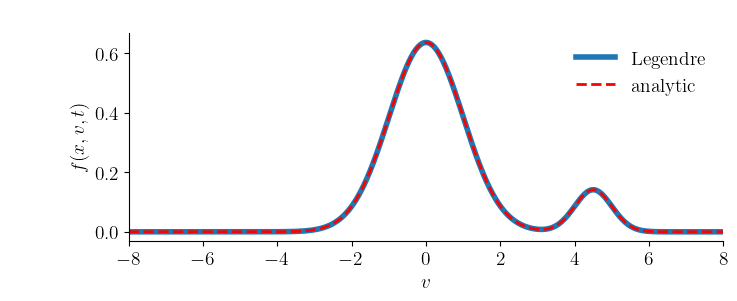

In [81]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(v_, f0/(setup.v_b - setup.v_a), linewidth=4, label="Legendre")
ax.plot(v_, 0.9 * np.exp(-0.5 * (v_ ** 2)) / np.sqrt(2) + 0.1 * np.exp(-2 * ((v_ - 4.5) ** 2)) * np.sqrt(2), linewidth=2, ls="--", color="red", label="analytic")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$v$")
_ = ax.set_ylabel(r"$f(x, v, t)$")
legend = ax.legend(ncols=1, fontsize=14, loc='upper right')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
ax.set_xlim(setup.v_a, setup.v_b)
plt.tight_layout()

# simulation results

In [82]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/legendre/bump_on_tail/sol_u_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/legendre/bump_on_tail/sol_t_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20200, 4001)
(4001,)


In [83]:
runtime = np.load("../../data/legendre/bump_on_tail/sol_runtime_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([19895.36701   ,  3117.55505514])

In [84]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [95]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv_e,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv_e,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv_e, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    # periodicity enforced
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_legendre(q_e=setup.q_e, q_i=setup.q_i,
                         C0_e=state_e_midpoint[0, :setup.Nx, ii], C0_i=np.ones(setup.Nx)/(setup.v_b - setup.v_a),
                         v_a=setup.v_a, v_b=setup.v_b)

    print(np.sum(rho))
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

1.3093970352429096e-11
1.3093970352429096e-11
1.3093970352429096e-11
1.3094414441638946e-11
1.3095746709268496e-11
1.3096079776175884e-11
1.3096412843083272e-11
1.3096967954595584e-11
1.3096856932293122e-11
1.3097967155317747e-11
1.3096967954595584e-11
1.3097301021502972e-11
1.3096967954595584e-11
1.3096190798478347e-11
1.3096190798478347e-11
1.3096412843083272e-11
1.3096523865385734e-11
1.3095968753873422e-11
1.3095746709268496e-11
1.3095524664663571e-11
1.3095191597756184e-11
1.3095968753873422e-11
1.3095080575453721e-11
1.3093415240916784e-11
1.3093304218614321e-11
1.3092971151706934e-11
1.3092749107102009e-11
1.3093193196311859e-11
1.3092527062497084e-11
1.3091971950984771e-11
1.3092082973287233e-11
1.3092082973287233e-11
1.3091305817169996e-11
1.3091527861774921e-11
1.3091083772565071e-11
1.3091305817169996e-11
1.3091749906379846e-11
1.3091416839472458e-11
1.3091083772565071e-11
1.3090972750262608e-11
1.3091527861774921e-11
1.3091194794867533e-11
1.3091971950984771e-11
1.309163888

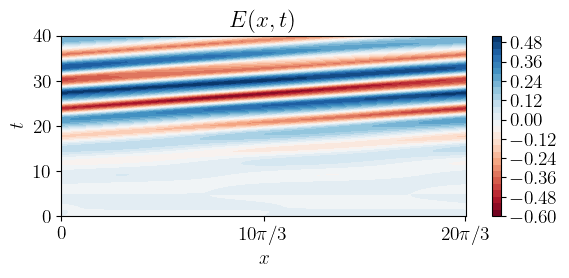

In [86]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

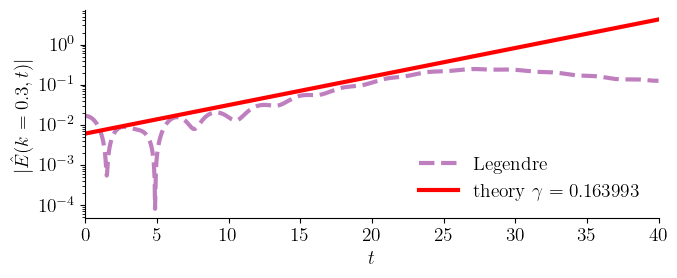

In [87]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="Legendre") 
ax.plot(sol_midpoint_t, 6e-3*np.exp(0.163993367317754*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/legendre/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

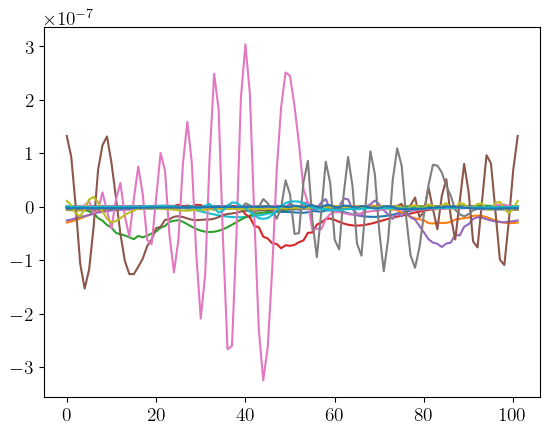

In [88]:
_ = plt.plot(state_e_midpoint[-1, :, ::200])

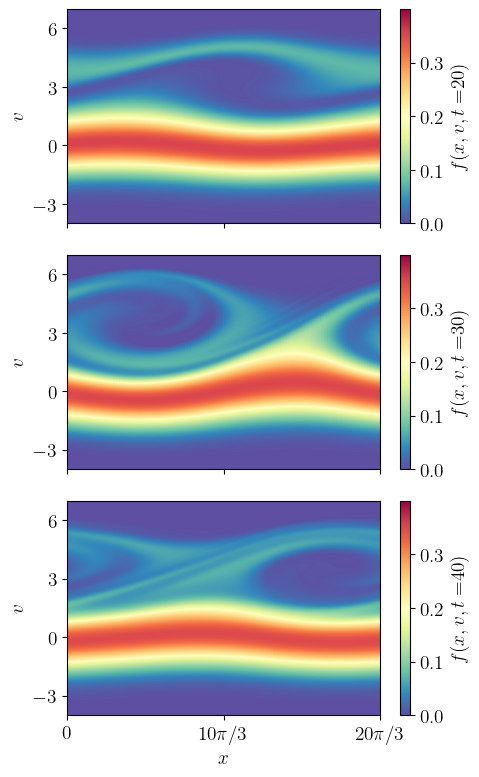

In [92]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, figsize=(5, 8), sharex=True)
for tt, ii in enumerate([len(sol_midpoint_t)//2, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e):
        distribution += np.outer(state_e_midpoint[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    pos = ax[tt].pcolormesh(x, v_, distribution.T, cmap="Spectral_r", vmin=0, vmax=0.4, shading="gouraud")
    ax[tt].set_yticks([-3, 0, 3, 6])
    ax[tt].set_ylabel("$v$")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    #ax[tt].set_title("$f(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt].set_ylim(-4, 7)

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt].set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
plt.tight_layout()
plt.savefig("../../figures/legendre/bump_on_tail/bump_on_tail_evolution_legendre.png", dpi=600)

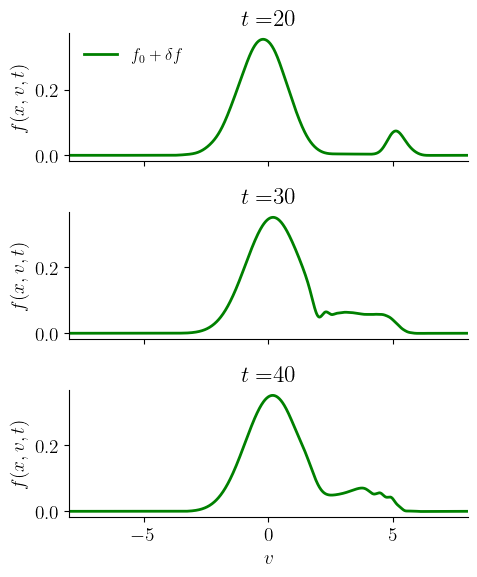

In [94]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 6), sharex=True)
for tt, ii in enumerate([2000, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e):
        distribution_L += np.outer(state_e_midpoint[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    _ = ax[tt].plot(v_, distribution_L[55, :], color="green", ls="-", label=r"$f_{0} + \delta f$", linewidth=2)
    ax[tt].set_title("$t = $" + str(int(sol_midpoint_t[ii])))
    ax[tt].spines['right'].set_visible(False)
    ax[tt].spines['top'].set_visible(False)
    ax[tt].set_ylabel("$f(x, v, t)$")
legend = ax[0].legend(ncols=1, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)
ax[-1].set_xlabel("$v$")
ax[-1].set_xlim(setup.v_a, setup.v_b)
plt.tight_layout()

# conservation laws: mass, momentum, and energy

### mass conservation

In [19]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)\
                        +total_mass_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

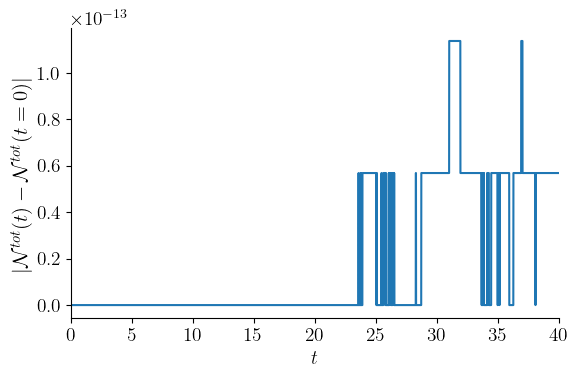

In [20]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [21]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_legendre(state=state_e_midpoint[:, :-1, ii],
                                                    v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_i_midpoint[:, :-1, ii], 
                                                     v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)

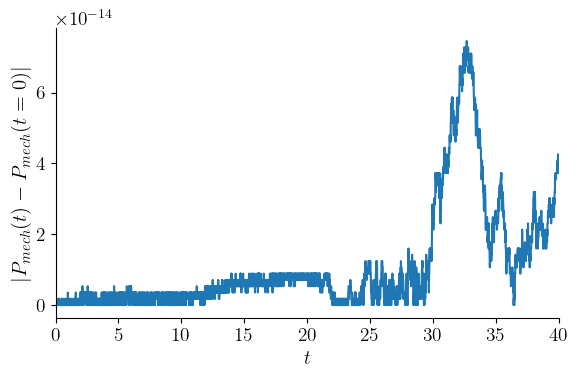

In [22]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [23]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

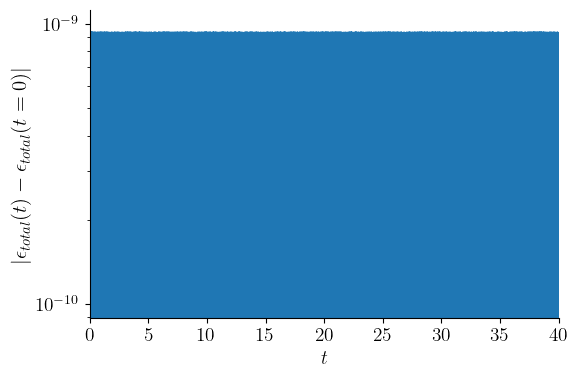

In [24]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

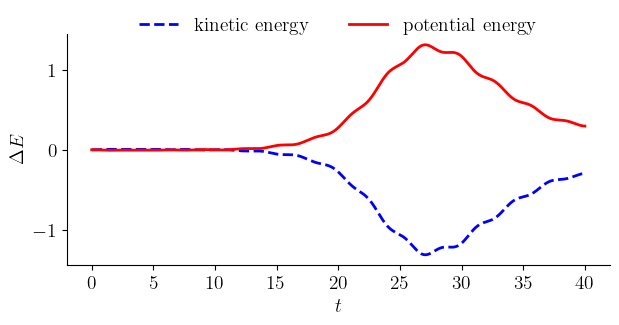

In [25]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

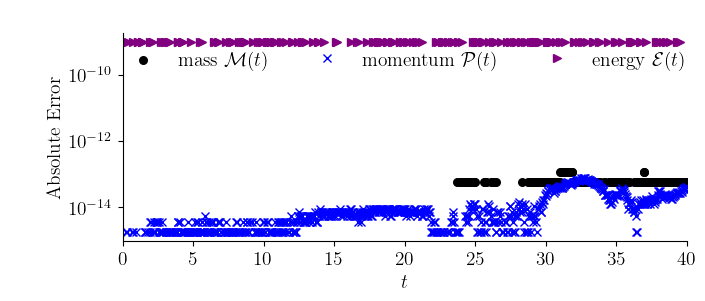

In [26]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()